In [78]:
!pip install itertools

ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


# Dependencies

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Data
This dataset is from the pre-print by Porto and Fogliatto:<br>
1. Porto BM, Fogliatto FS. Enhancing emergency department patient arrival forecasting: a study using feature engineering and advanced machine learning algorithms. Published online February 2, 2024. doi:10.21203/rs.3.rs-3891200/v1

It has data from 13 emergency departments, and includes local temperature information (min, max and mean) as well as one-hot encoded day-of-week, day-of-month, and month data.   


In [40]:
df = pd.read_excel('ed _visit_dataset.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df['day_of_the_year'] = df['Date'].dt.dayofyear
df['trend'] = range(1, len(df) + 1)

# EDA

In [41]:
df.head(1)

id       Date  attendences  min   max  average_temperature  monthday  \
0  aku 2014-01-01        149.0  6.5  21.0                 17.0         1   

   month  sunday  monday  ...  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec  \
0      1       0       0  ...    0    0    0    0    0    0    0    0   

   day_of_the_year  trend  
0                1      1  

[1 rows x 30 columns]

In [42]:
df.describe()

Date   attendences           min  \
count                          14170  14170.000000  14170.000000   
mean   2015-06-29 16:45:21.467889920    170.980918     12.142562   
min              2014-01-01 00:00:00      0.000000     -6.300000   
25%              2014-09-30 00:00:00     80.000000      7.900000   
50%              2015-06-29 12:00:00    169.000000     12.200000   
75%              2016-03-28 00:00:00    212.000000     16.000000   
max              2016-12-31 00:00:00    833.000000     33.000000   
std                              NaN    114.491018      6.247777   

                max  average_temperature      monthday         month  \
count  14170.000000         14170.000000  14170.000000  14170.000000   
mean      22.301207            21.210127     15.723853      6.496260   
min       -0.300000            -2.900000      1.000000      1.000000   
25%       17.100000            14.050000      8.000000      4.000000   
50%       21.900000            20.650000     16.000000      7.000000   
75%       28.000000            28.350000     23.000000      9.000000   
max       44.800000            52.300000     31.000000     12.000000   
std        8.256890             9.773623      8.801696      3.440718   

             sunday        monday       tuesday  ...           May  \
count  14170.000000  14170.000000  14170.000000  ...  14170.000000   
mean       0.142343      0.142343      0.142343  ...      0.085321   
min        0.000000      0.000000      0.000000  ...      0.000000   
25%        0.000000      0.000000      0.000000  ...      0.000000   
50%        0.000000      0.000000      0.000000  ...      0.000000   
75%        0.000000      0.000000      0.000000  ...      0.000000   
max        1.000000      1.000000      1.000000  ...      1.000000   
std        0.349414      0.349414      0.349414  ...      0.279369   

                Jun           Jul           Aug           Sep           Oct  \
count  14170.000000  14170.000000  14170.000000  14170.000000  14170.000000   
mean       0.082569      0.085321      0.085321      0.082569      0.084121   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   
std        0.275239      0.279369      0.279369      0.275239      0.277580   

                Nov           Dec  day_of_the_year         trend  
count  14170.000000  14170.000000     14170.000000  14170.000000  
mean       0.080452      0.083133       182.372477   7085.500000  
min        0.000000      0.000000         1.000000      1.000000  
25%        0.000000      0.000000        91.000000   3543.250000  
50%        0.000000      0.000000       182.000000   7085.500000  
75%        0.000000      0.000000       273.000000  10627.750000  
max        1.000000      1.000000       366.000000  14170.000000  
std        0.272001      0.276093       105.196531   4090.670992  

[8 rows x 29 columns]

In [43]:
df.dtypes

id                             object
Date                   datetime64[ns]
attendences                   float64
min                           float64
max                           float64
average_temperature           float64
monthday                        int64
month                           int64
sunday                          int64
monday                          int64
tuesday                         int64
wednesday                       int64
thursday                        int64
friday                          int64
saturday                        int64
day_of_the_week                 int64
Jan                             int64
Feb                             int64
Mar                             int64
Apr                             int64
May                             int64
Jun                             int64
Jul                             int64
Aug                             int64
Sep                             int64
Oct                             int64
Nov         

In [44]:
df['id'].value_counts()

id
amc             1096
antoniushove    1096
arma            1096
bronovo         1096
davis           1096
joon            1096
kem             1096
pm              1096
rg              1096
rph             1096
scg             1096
westeinde       1096
aku             1018
Name: count, dtype: int64

<Axes: xlabel='Date', ylabel='attendences'>

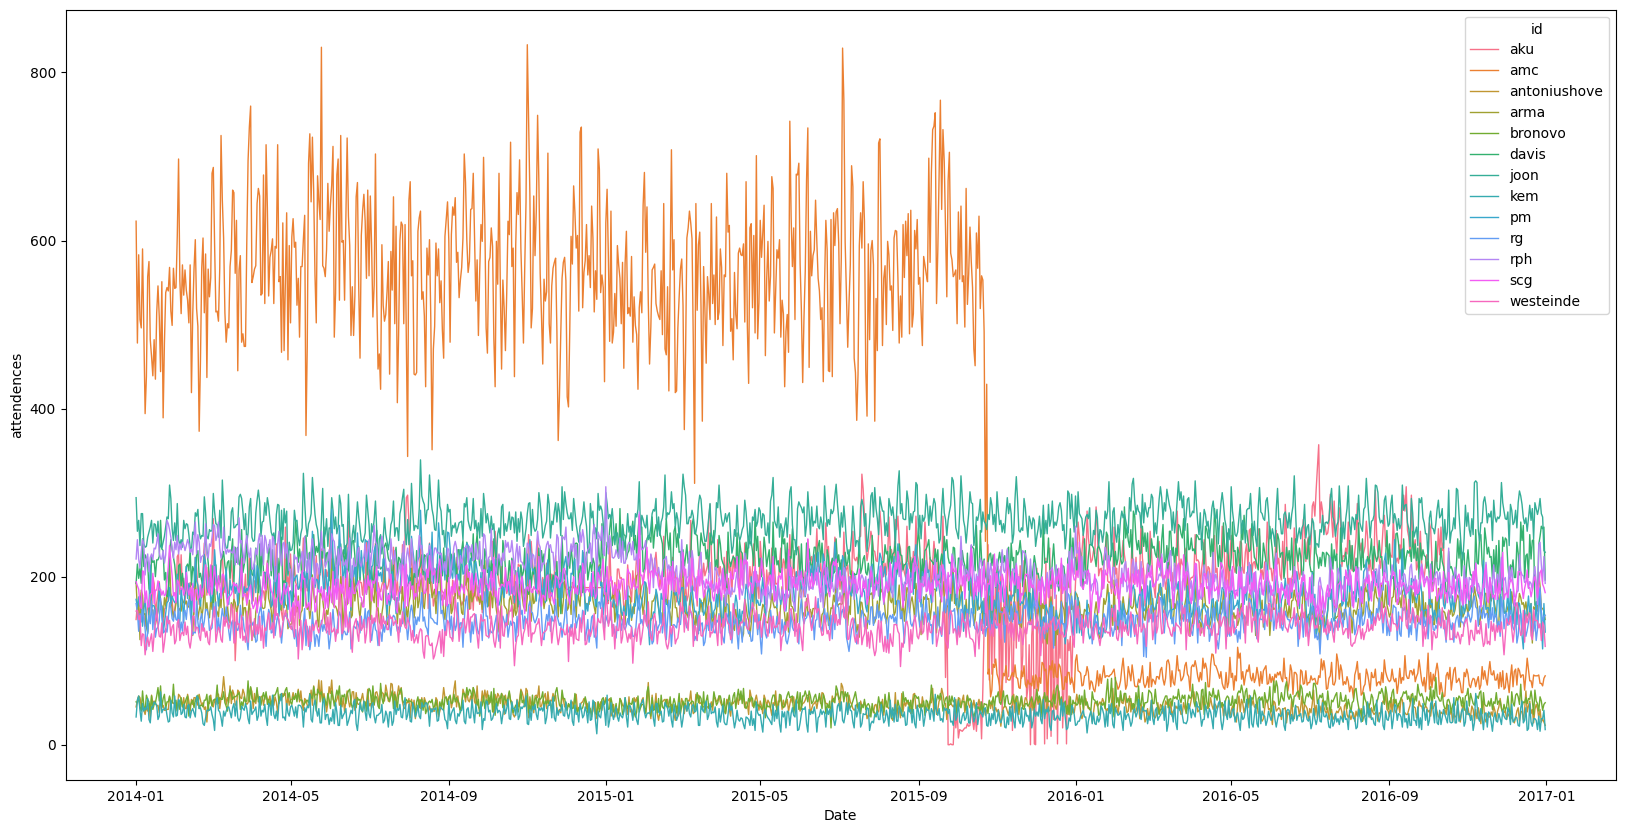

In [45]:
plt.figure(figsize=(20, 10))
sns.lineplot(data=df, x='Date', y='attendences', hue='id', linewidth=1)

It looks like 'amc' has a pretty dramatic decrease suddenly in 2015...

<Axes: xlabel='Date', ylabel='attendences'>

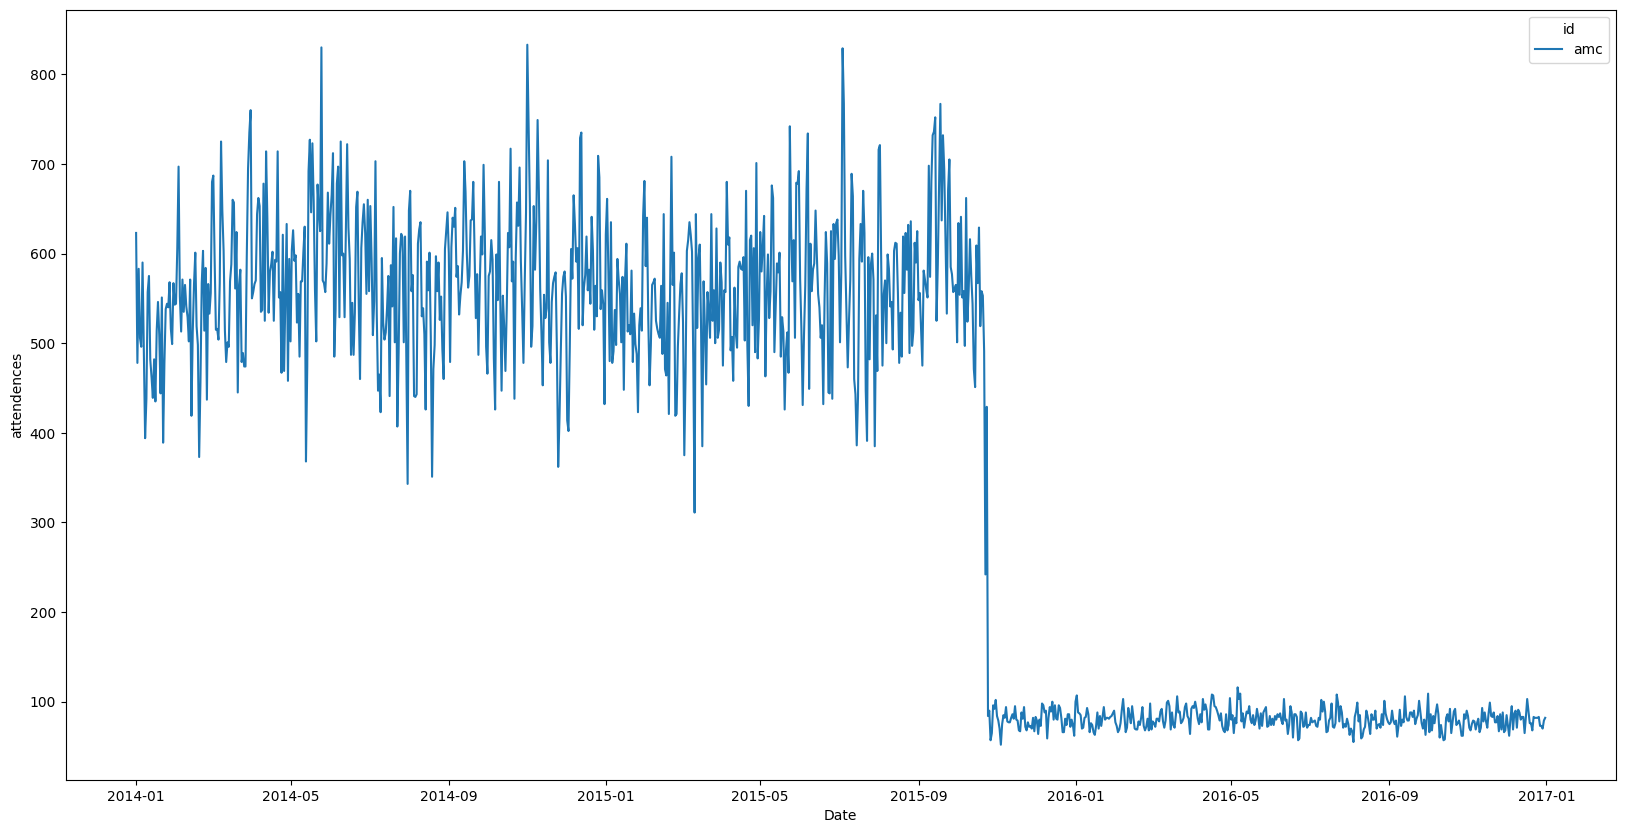

In [46]:
dfs = df.loc[df['id'] == 'amc']
plt.figure(figsize=(20, 10))
sns.lineplot(data=dfs, x='Date', y='attendences', hue='id')


I'm not sure what happened at this point, but I might decide to drop this from the dataset since it is such an extreme change.

Let's look at them all together with amc removed    

<Axes: xlabel='Date', ylabel='attendences'>

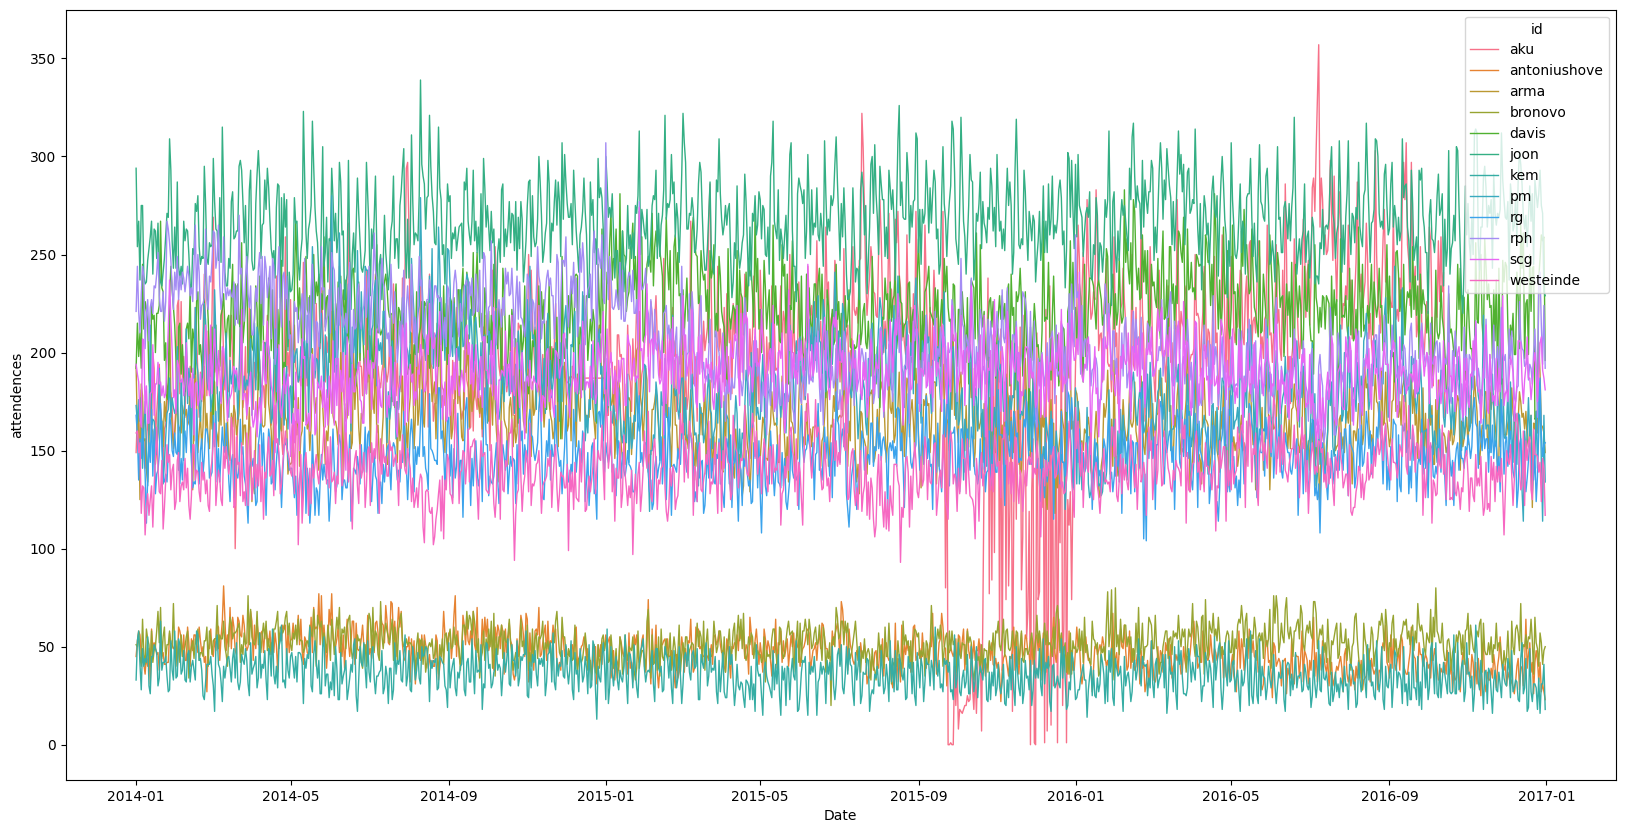

In [47]:
dfna = df.loc[df['id'] != 'amc']
plt.figure(figsize=(20, 10))
sns.lineplot(data=dfna, x='Date', y='attendences', hue='id',linewidth=1)

There's one more with major variability in there... looks like it's Aku

<Axes: xlabel='Date', ylabel='attendences'>

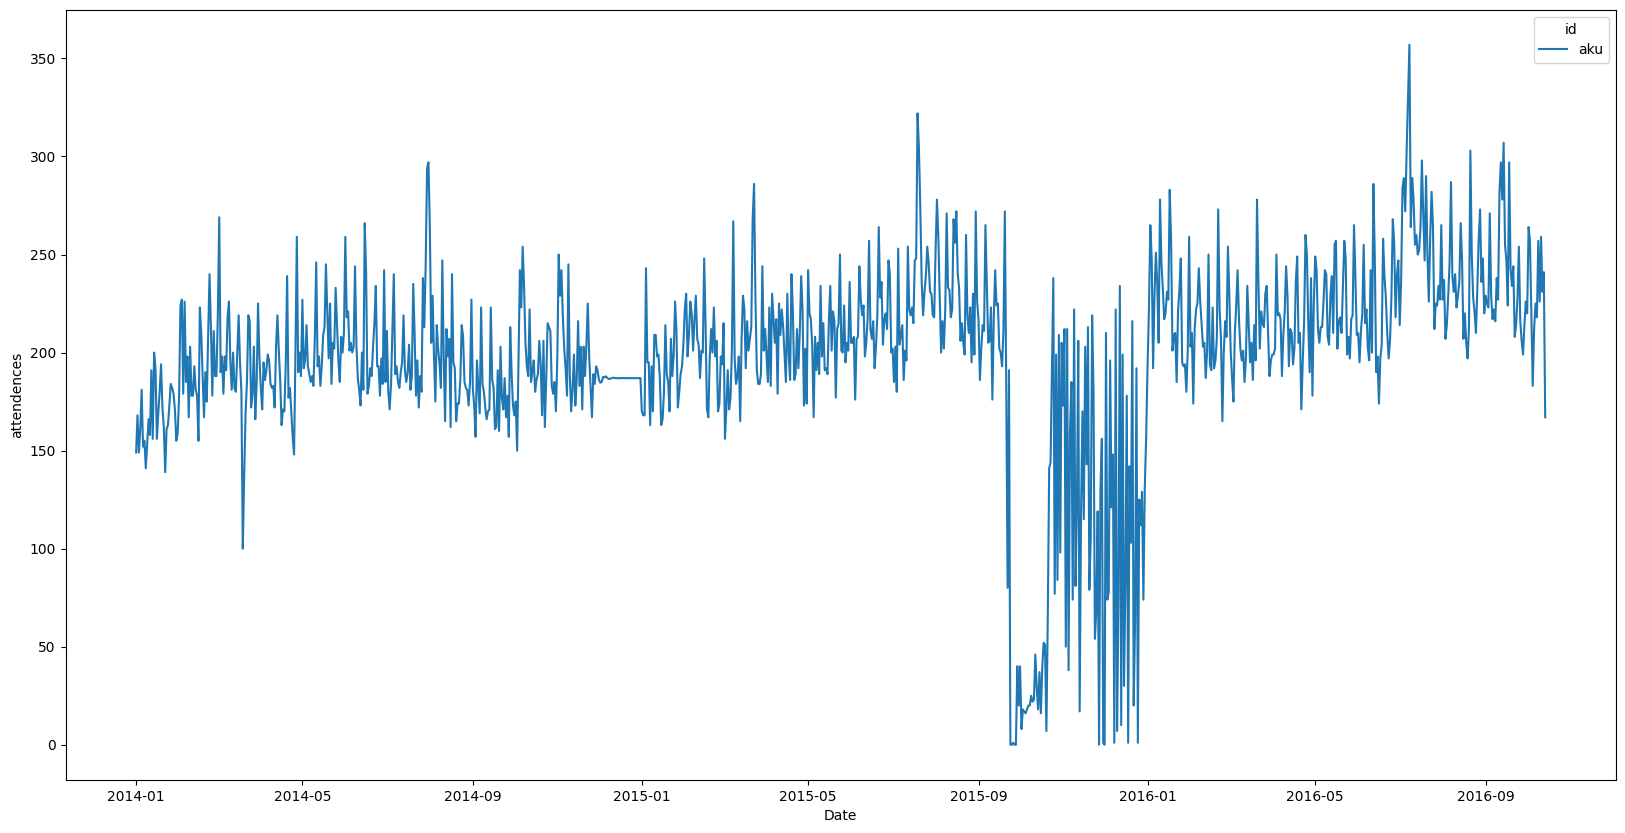

In [48]:
dfs = df.loc[df['id'] == 'aku']
plt.figure(figsize=(20, 10))
sns.lineplot(data=dfs, x='Date', y='attendences', hue='id')

Again, a possible outlier dataset which might be worth dropping...

<Axes: xlabel='Date', ylabel='attendences'>

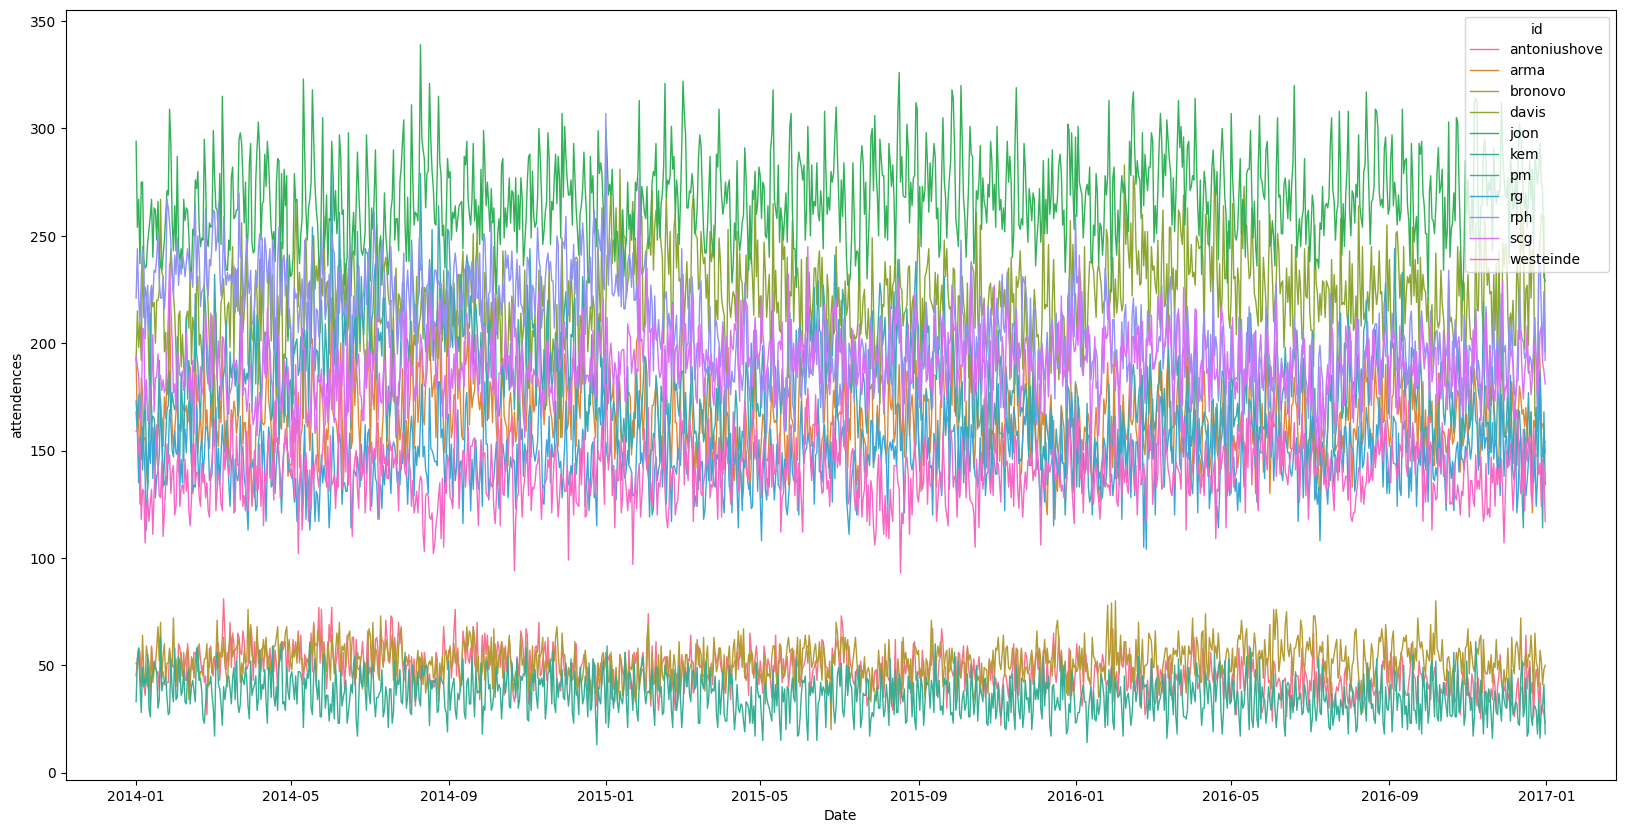

In [49]:
dfna = df.loc[df['id'] != 'amc']
dfnb = dfna.loc[dfna['id'] != 'aku']
plt.figure(figsize=(20, 10))
sns.lineplot(data=dfnb, x='Date', y='attendences', hue='id',linewidth=1)

That looks a lot prettier. Let's use this to see if there are any clear weekly or seasonal trends accross the whole dataset.

<Axes: xlabel='day_of_the_week'>

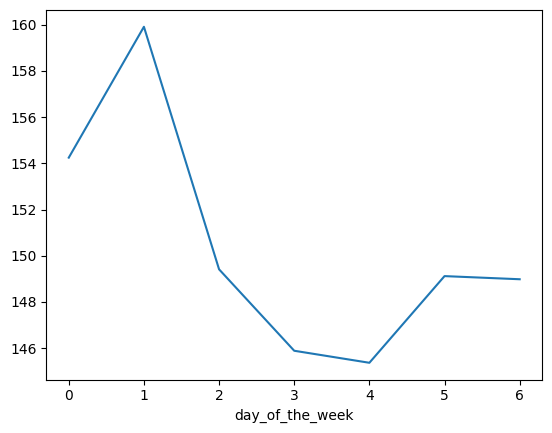

In [50]:
dfnb.groupby('day_of_the_week')['attendences'].mean().plot(kind='line')

<Axes: xlabel='day_of_the_year'>

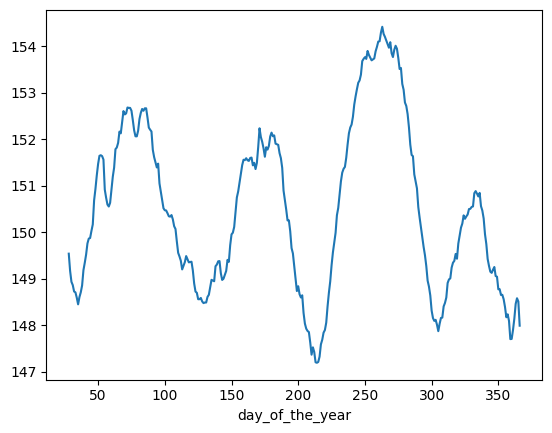

In [51]:
dfnb.groupby('day_of_the_year')['attendences'].mean().rolling(28).mean().plot(kind='line')

It looks like there is some general seasonality and weekly fluctuation across the entire dataset.

# ARIMA Model

ARIMA probably isn't ideal given the seasonality seen above, but let's give it a shot anyway.

source: https://medium.com/@baotramduong/time-series-forecasting-using-arima-and-sarima-in-python-5dad8685da59

In [68]:
dfd = df.loc[df['id'] == 'davis'].set_index('trend')
#isolate date and attendences columns with date as index
dfd = dfd[['Date', 'attendences']].set_index('Date')

In [69]:
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    
check_stationarity(dfd)

ADF Statistic: -3.1727981751305916
p-value: 0.021614214327113423
Critical Values: {'1%': -3.4364533503600962, '5%': -2.864234857527328, '10%': -2.568204837482531}


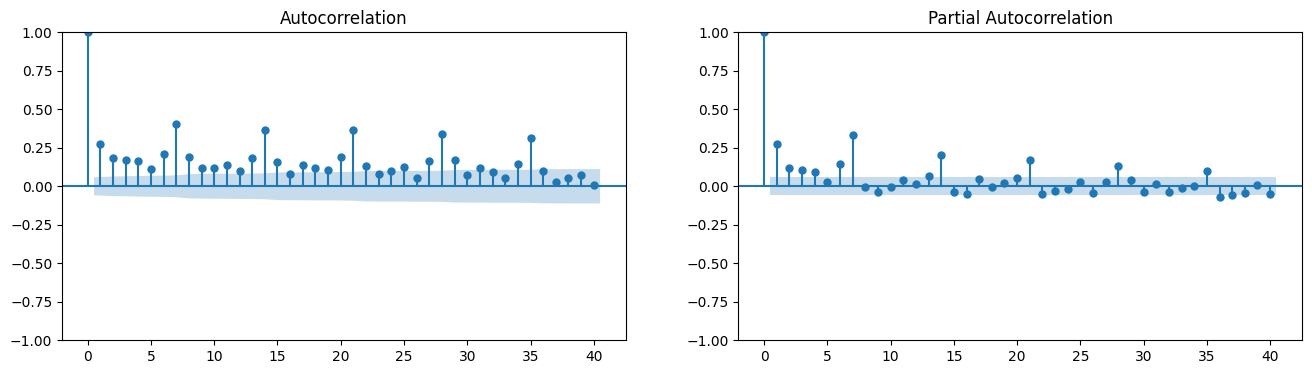

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(dfd, lags=40, ax=ax1)
plot_pacf(dfd, lags=40, ax=ax2)
plt.show()

In [75]:
order = (2, 0, 2) # Replace p, d, q with appropriate values from ACF and PACF plots
arima_model = ARIMA(dfd, order=order)
arima_results = arima_model.fit()

# Print model summary
print(arima_results.summary())

c:\Users\kentm\Documents\Jupyter Notebooks\ed visit timeseries\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kentm\Documents\Jupyter Notebooks\ed visit timeseries\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kentm\Documents\Jupyter Notebooks\ed visit timeseries\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kentm\Documents\Jupyter Notebooks\ed visit timeseries\.conda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-s

                               SARIMAX Results                                
Dep. Variable:            attendences   No. Observations:                 1096
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -4816.138
Date:                Wed, 15 May 2024   AIC                           9644.276
Time:                        09:08:46   BIC                           9674.273
Sample:                    01-01-2014   HQIC                          9655.626
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        220.6774      3.055     72.236      0.000     214.690     226.665
ar.L1          0.0415      0.027      1.564      0.118      -0.010       0.094
ar.L2          0.9231      0.026     35.736      0.0

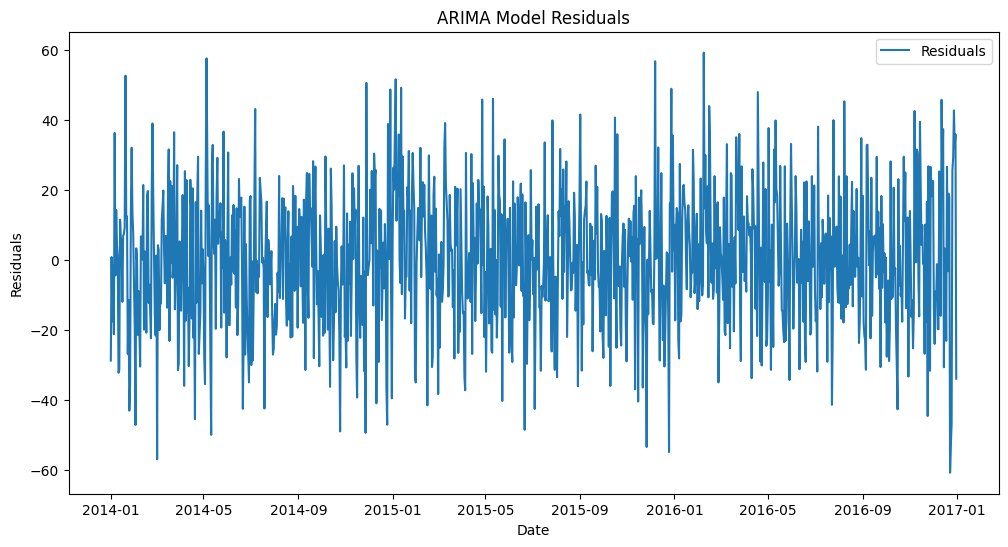

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(arima_results.resid.index, arima_results.resid, label='Residuals')
plt.title('ARIMA Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.show()

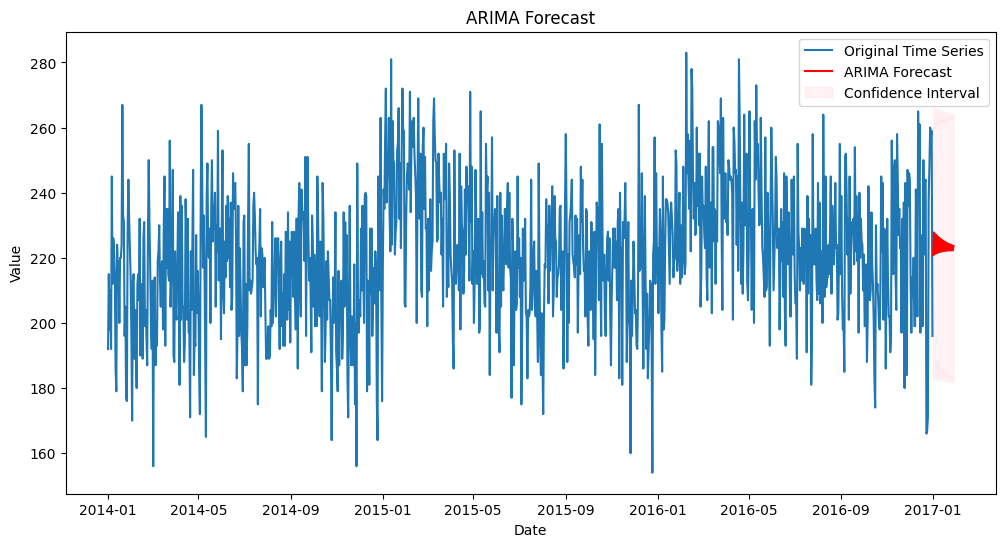

In [77]:
forecast_steps = 28  # Number of steps to forecast
arima_forecast = arima_results.get_forecast(steps=forecast_steps)

# Get forecast values and confidence intervals
forecast_mean = arima_forecast.predicted_mean
forecast_ci = arima_forecast.conf_int()


# Visualize the forecast
plt.figure(figsize=(12, 6))
plt.plot(dfd.index, dfd, label='Original Time Series')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='ARIMA Forecast')
plt.fill_between(forecast_ci.index, forecast_ci['lower attendences'], forecast_ci['upper attendences'], color='pink', alpha=0.2, label='Confidence Interval')
plt.title('ARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

# SARIMAX

source: https://medium.com/swlh/a-brief-introduction-to-arima-and-sarima-modeling-in-python-87a58d375def

In [80]:
import statsmodels.api as sm
import itertools
# Grid Search
p = d = q = range(0,3) # p, d, and q can be either 0, 1, or 2
pdq = list(itertools.product(p,d,q)) # gets all possible combinations of p, d, and q 
p2 = d2 = q2 = range(0, 2) # second set of p's, d's, and q's
pdq2 = list(itertools.product(p2,d2,q2)) # simular too code above but for seasonal parameters
s = 12 # here I use twelve but the number here is representative of the periodicty of the seasonal cycle
pdqs2 = [(c[0], c[1], c[2], s) for c in pdq2]
combs = {}
aics = []
# Grid Search Continued
for combination in pdq:
    for seasonal_combination in pdqs2:
        try:
            model = sm.tsa.statespace.SARIMAX(dfd, order=combination, seasonal_order=seasonal_combination,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            model = model.fit()
            combs.update({model.aic : [combination, seasonal_combination]})
            aics.append(model.aic)
            
        except:
            continue
            
best_aic = min(aics)
# Modeling and forcasting
model = sm.tsa.statespace.SARIMAX(dfd, order=combs[best_aic][0], seasonal_order=combs[best_aic][1],
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
model = model.fit()
model.forecast(7)

c:\Users\kentm\Documents\Jupyter Notebooks\ed visit timeseries\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kentm\Documents\Jupyter Notebooks\ed visit timeseries\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kentm\Documents\Jupyter Notebooks\ed visit timeseries\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\kentm\Documents\Jupyter Notebooks\ed visit timeseries\.conda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2017-01-01    219.264858
2017-01-02    228.932237
2017-01-03    221.328613
2017-01-04    230.632086
2017-01-05    229.362944
2017-01-06    230.316945
2017-01-07    220.321388
Freq: D, Name: predicted_mean, dtype: float64

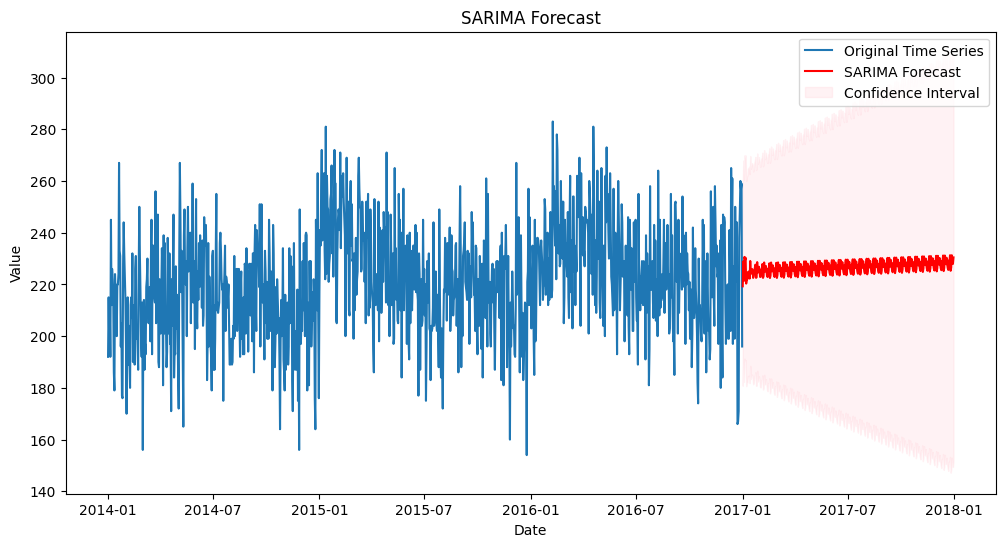

In [83]:
forecast_steps = 365  # Number of steps to forecast
sarima_forecast = model.get_forecast(steps=forecast_steps)

# Get forecast values and confidence intervals
forecast_mean = sarima_forecast.predicted_mean
forecast_ci = sarima_forecast.conf_int()


# Visualize the forecast
plt.figure(figsize=(12, 6))
plt.plot(dfd.index, dfd, label='Original Time Series')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='SARIMA Forecast')
plt.fill_between(forecast_ci.index, forecast_ci['lower attendences'], forecast_ci['upper attendences'], color='pink', alpha=0.2, label='Confidence Interval')
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

Clearly this is missing some of the yearly seasonality for some reason...

# Additional Feature Engineering

In [ ]:
#Adding a prior n day moving average